In [1]:
#Libaries and Settings
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels import regression
from pandas import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import cvxopt as opt
from cvxopt import blas, solvers, printing 
solvers.options['show_progress'] = False
printing.options['dformat'] = '%.4f'
import pyfolio as pf
%matplotlib inline
from scipy.stats import norm

C:\Users\maxru\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
#Functions
def historical_moments(returns):
    historical_returns = opt.matrix(np.mean(np.array(returns.iloc[1:,:].T), axis=1))
    historical_H = opt.matrix(np.cov(returns.iloc[1:,:].T))
    historical_S = coskew(returns.iloc[1:,:].T)
    historical_K = cokurt(returns.iloc[1:,:].T)
    return historical_returns, historical_H, historical_S, historical_K

def mvo(mu, H):
    n = len(mu)
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1)) # n x 1 matrix of 0 values
    A = opt.matrix(1.0, (1, n)) # 1 x n matrix of 1 values  
    b = opt.matrix(1.0) # 1 x 1 matrix of 1 value
    #G, h matrices -> weights are non-negative (no shorting)
    #A, b matrices -> sum of weights equal to 1
    #Other considerations: illiquid asset weight limits e.g. real estate <20%
    N = 100 
    gammas = [10**(5.0 * t/N - 1.0) for t in range(N)] # Risk-aversion
    portfolios = [solvers.qp(gamma*H, -mu, G, h, A, b)['x'] for gamma in gammas]
    returns = [blas.dot(mu, weights) for weights in portfolios]  
    std = [np.sqrt(blas.dot(weights, H*weights)) for weights in portfolios]
    sharpe = np.divide(returns, std)
    index = np.where(sharpe == max(sharpe))[0][0]
    return portfolios, returns, std, index

def equal_weight(returns):
    eq_weights = opt.matrix(1/len(returns.columns), (len(returns.columns), 1))
    return eq_weights
    
def risk_parity_variance(returns):
    rp_var_weights = [0] * len(returns.columns)
    for i in range(len(returns.columns)):
        rp_var_weights[i] = 1/np.var(returns.iloc[:,i])
    rp_var_weights = opt.matrix(rp_var_weights) 
    rp_var_weights = rp_var_weights/sum(rp_var_weights)
    return rp_var_weights

def risk_parity_volatility(returns):
    rp_vol_weights = [0] * len(returns.columns)
    for i in range(len(returns.columns)):
        rp_vol_weights[i] = 1/(np.var(returns.iloc[:,i]))**0.5
    rp_vol_weights = opt.matrix(rp_vol_weights) 
    rp_vol_weights = rp_vol_weights/sum(rp_vol_weights)
    return rp_vol_weights

def asset_risk_contribution(weights, V):
    weights = np.matrix(weights)
    std = np.sqrt(np.dot(np.dot(weights, V), weights.T))[0,0]
    asset_RC = np.multiply(weights.T, V * weights.T)/std
    return asset_RC

def risk_budget_objective_error(weights, args):
    V = args[0]
    asset_risk_budget = args[1]
    asset_RC = asset_risk_contribution(weights,V)
    weights = np.matrix(weights)
    std = np.sqrt(np.dot(np.dot(weights, V), weights.T))[0,0]
    asset_risk_target = opt.matrix(np.multiply(std, asset_risk_budget))
    error = sum(np.square(asset_RC - asset_risk_target.T))[0]
    return error

def equal_risk_contribution(V):
    initial_weights = opt.matrix(1/len(returns.columns), (len(returns.columns), 1)).T 
    asset_risk_budget = opt.matrix(1/len(returns.columns), (len(returns.columns), 1)).T
    #x refers to weights
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})
    optimal_result = minimize(fun = risk_budget_objective_error,
                               x0 = initial_weights,
                               args = [V, asset_risk_budget],
                               method='SLSQP',
                               constraints = constraints,
                               tol = 1e-10,
                               options = {'disp': False})
    
    weights = opt.matrix(optimal_result.x)
    return weights
    
def coskew(df):
    n = len(df)
    mtx = opt.matrix(np.zeros(shape = (n, n**2))) # n x n**2 format
    mean = opt.matrix(np.mean(np.array(df), axis=1))
    v1 = opt.matrix(np.array(df) - mean).T
    for i in range(n):
        for j in range(n):
            for k in range(n):
                vals = np.mean(np.multiply(np.multiply(v1[:,i],v1[:,j]), v1[:,k]))
                mtx[j,k+n*i] = vals/(np.std(v1[:,i])*np.std(v1[:,j])*np.std(v1[:,k]))
    return mtx
 
def cokurt(df):
    n = len(df)
    mtx = opt.matrix(np.zeros(shape = (n, n**3))) # n x n**3 format
    mean = opt.matrix(np.mean(np.array(df), axis=1))
    v1 = opt.matrix(np.array(df) - mean).T
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    vals = np.mean(np.multiply(np.multiply(np.multiply(v1[:,i], v1[:,j]), v1[:,k]), v1[:,l]))
                    mtx[j,k+n*i+(n**2)*l] = vals/(np.std(v1[:,i])*np.std(v1[:,j])*np.std(v1[:,k])*np.std(v1[:,l]))
    return mtx

def portfolio_return(weights, args):
    returns = args[0]
    port_return = np.dot(weights.T, returns)
    return port_return

def portfolio_variance(weights, args):
    covariance = args[1]
    port_cov = np.dot(np.dot(weights.T, covariance), weights)
    return port_cov

def portfolio_skew(weights, args):
    coskew = args[2]
    W_W = np.kron(weights, weights)
    port_skew = np.dot(np.dot(weights.T, coskew), W_W)
    return port_skew

def portfolio_kurt(weights, args):
    cokurt = args[3]
    W_W_W = np.kron(np.kron(weights, weights), weights)
    port_kurt = np.dot(np.dot(weights.T, cokurt), W_W_W)
    return port_kurt
    
def neg_portfolio_return(weights, args):
    port_return = portfolio_return(weights, args)
    return -port_return    

def neg_portfolio_skew(weights, args):
    port_skew = portfolio_skew(weights, args)
    return -port_skew

def PGP_joint_objective_error(weights, args):
    moments = args[0:4]
    abs_return_deviation = abs(portfolio_return(weights, args) - args[8])
    abs_variance_deviation = abs(portfolio_variance(weights, args) - args[9])
    abs_skew_deviation = abs(portfolio_skew(weights, args) - args[10])
    abs_kurt_deviation = abs(portfolio_kurt(weights, args) - args[11])
    Z = abs_return_deviation**args[4] + abs_variance_deviation**args[5] + abs_skew_deviation**args[6] + abs_kurt_deviation**args[7]
    return Z
    
def PGP_4_moments(V):
    initial_weights = opt.matrix(1/len(returns.columns), (len(returns.columns), 1)).T
    return_pref, variance_pref, skew_pref, kurt_pref = V[4:8]
    #x refers to weights
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})
    optimise_return = minimize(fun = neg_portfolio_return,
                                 x0 = initial_weights,
                                 args = [historical_returns, historical_H, historical_S, historical_K],
                                 constraints = constraints,
                                 tol = 1e-10,
                                 options = {'disp': False})
    max_return_weights = opt.matrix(optimise_return.x)
    max_return = optimise_return.fun * -1
    
    optimise_variance = minimize(fun = portfolio_variance,
                                 x0 = initial_weights,
                                 args = [historical_returns, historical_H, historical_S, historical_K],
                                 constraints = constraints,
                                 tol = 1e-10,
                                 options = {'disp': False})
    min_variance_weights = opt.matrix(optimise_variance.x)
    min_variance = optimise_variance.fun
    
    optimise_skew = minimize(fun = neg_portfolio_skew,
                                 x0 = initial_weights,
                                 args = [historical_returns, historical_H, historical_S, historical_K],
                                 constraints = constraints,
                                 tol = 1e-10,
                                 options = {'disp': False})
    max_skew_weights = opt.matrix(optimise_skew.x)
    max_skew = optimise_skew.fun * -1
    
    optimise_kurtosis = minimize(fun = portfolio_kurt,
                                 x0 = initial_weights,
                                 args = [historical_returns, historical_H, historical_S, historical_K],
                                 constraints = constraints,
                                 tol = 1e-10,
                                 options = {'disp': False})
    min_kurtosis_weights = opt.matrix(optimise_kurtosis.x)
    min_kurtosis = optimise_kurtosis.fun
    
    PGP_optimise = minimize(fun = PGP_joint_objective_error, 
                            x0 = initial_weights, 
                            args = [historical_returns, historical_H, historical_S, historical_K, 
                                    return_pref, variance_pref, skew_pref, kurt_pref, 
                                   max_return, min_variance, max_skew, min_kurtosis],
                            constraints = constraints,
                            tol = 1e-10,
                            options = {'disp': False})
    PGP_4_moments_weights = opt.matrix(PGP_optimise.x)
    return PGP_4_moments_weights

In [3]:
# Historical Data
assets = pd.read_csv('Opportunity_Set.csv', parse_dates = [0])
assets.set_index('Date', inplace=True)
returns = assets.pct_change().iloc[1:]
historical_returns, historical_H, historical_S, historical_K = historical_moments(returns)
print(f'Sample Size (years): {round(len(assets)/12,2)}')
print('Latest Data: April 2020')
print(assets.head(1))
print(assets.tail(1))
print('Historical Returns:')
print(historical_returns.T)

Sample Size (years): 18.5
Latest Data: April 2020
            10Y Bond    World     EM    GSCI
Date                                        
2000-12-31   1718.55  2487.61  100.0  4147.9
            10Y Bond    World      EM     GSCI
Date                                          
2019-05-31   4173.31  5939.69  463.69  2391.41
Historical Returns:
[0.0043 0.0048 0.0084 0.0313]



In [44]:
len(returns)

221

In [4]:
#Subjective Forward-Looking Inputs
expected_returns = opt.matrix([0.05, 0.045, 0.07, 0.07])
expected_volatility = opt.matrix([0.1, 0.1, 0.1, 0.1]).T
expected_correlations = opt.matrix([[1, 0.6, 0.1, 0.7], [0.6, 1, 0.1, 0.6], [0.1, 0.1, 1, 0.1], [0.7, 0.6, 0.1, 1]])
expected_H = opt.matrix(np.multiply(np.dot(expected_volatility.T, expected_volatility), expected_correlations))

print('Forward-Looking Returns:')
print(expected_returns.T)
print('Forward-Looking Volatility:')
print(expected_volatility)
print('Forward-Looking Covariance:')
print(expected_H)

#GARCH models for dynamic covariance matrix

Forward-Looking Returns:
[0.0500 0.0450 0.0700 0.0700]

Forward-Looking Volatility:
[0.1000 0.1000 0.1000 0.1000]

Forward-Looking Covariance:
[0.0100 0.0060 0.0010 0.0070]
[0.0060 0.0100 0.0010 0.0060]
[0.0010 0.0010 0.0100 0.0010]
[0.0070 0.0060 0.0010 0.0100]



,Weights,Return,Volatility,Sharpe Ratio,Skewness,Kurtosis
Mean-Variance,"[0.7340797765431948, 0.15179194389741704, 0.10...",0.00499989,0.0175227,0.285338,-0.00832265,1.16719
Min-Variance,"[0.7336733645253218, 0.2649267719914865, 3.250...",0.00446711,0.0161931,0.275864,-0.0246121,1.14497
EQ,"[0.25, 0.25, 0.25, 0.25]",0.0121933,0.135549,0.0899546,0.0391804,0.893835
ERC,"[0.6298673344407368, 0.2137122769641745, 0.136...",0.00549445,0.0211383,0.259929,-0.0584076,0.719675
RP Variance,"[0.7270632060355307, 0.18285953640552285, 0.08...",0.00477831,0.0170367,0.280471,-0.017061,1.12335
RP Volatility,"[0.5285084566686611, 0.2650480811591346, 0.184...",0.00576715,0.0245229,0.235174,-0.101302,0.569613
"PGP 4 Moments 1,1,1,1","[0.4648123723372786, 0.20908215173965453, 0.16...",0.00939816,0.0871571,0.10783,-0.036296,0.410568
"PGP 4 Moments 1,1,0,0","[0.3975593208070704, 8.353777739000812e-17, 0....",0.00781013,0.041854,0.186604,-0.138761,0.674151
"PGP 4 Moments 3,1,2,1","[0.22439733885670043, -2.333119430685264e-16, ...",0.0252387,0.412375,0.0612033,6.56126,74.4396
"PGP 4 Moments 1,3,1,3","[0.4787736490972402, 0.07180812036154773, 0.21...",0.0114375,0.123678,0.0924779,0.0913611,0.711898


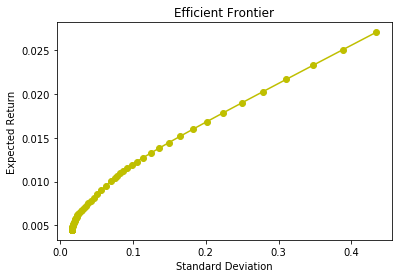

In [5]:
#Historical In-Sample Performance
historical_performance = pd.DataFrame(index = ['Mean-Variance', 'Min-Variance', 'EQ', 'ERC', 'RP Variance', 'RP Volatility', 
                                               'PGP 4 Moments 1,1,1,1', 'PGP 4 Moments 1,1,0,0', 'PGP 4 Moments 3,1,2,1', 'PGP 4 Moments 1,3,1,3'], 
                          columns = ['Weights','Return','Volatility', 'Sharpe Ratio', 'Skewness', 'Kurtosis']) 

weights, port_returns, std, index = mvo(historical_returns, historical_H)
historical_performance.loc['Mean-Variance', 'Weights'] = weights[index].T
historical_performance.loc['Min-Variance', 'Weights'] = weights[-1].T
historical_performance.loc['EQ', 'Weights'] = equal_weight(returns).T
historical_performance.loc['ERC', 'Weights'] = equal_risk_contribution(historical_H).T
historical_performance.loc['RP Variance', 'Weights'] = risk_parity_variance(returns).T
historical_performance.loc['RP Volatility', 'Weights'] = risk_parity_volatility(returns).T
historical_performance.loc['PGP 4 Moments 1,1,1,1', 'Weights'] = PGP_4_moments([historical_returns, historical_H, historical_S, historical_K, 1, 1, 1, 1]).T
historical_performance.loc['PGP 4 Moments 1,1,0,0', 'Weights'] = PGP_4_moments([historical_returns, historical_H, historical_S, historical_K, 1, 1, 0, 0]).T
historical_performance.loc['PGP 4 Moments 3,1,2,1', 'Weights'] = PGP_4_moments([historical_returns, historical_H, historical_S, historical_K, 3, 1, 2, 1]).T
historical_performance.loc['PGP 4 Moments 1,3,1,3', 'Weights'] = PGP_4_moments([historical_returns, historical_H, historical_S, historical_K, 1, 3, 1, 3]).T
for i in historical_performance.index:
    historical_performance.loc[i, 'Return'] = np.dot(historical_performance.loc[i, 'Weights'], historical_returns)[0][0]
    historical_performance.loc[i, 'Volatility'] = portfolio_variance(historical_performance.loc[i, 'Weights'].T, [historical_returns, historical_H, historical_S, historical_K])[0][0]**0.5
    historical_performance.loc[i, 'Skewness'] = portfolio_skew(historical_performance.loc[i, 'Weights'].T, [historical_returns, historical_H, historical_S, historical_K])[0][0]
    historical_performance.loc[i, 'Kurtosis'] = portfolio_kurt(historical_performance.loc[i, 'Weights'].T, [historical_returns, historical_H, historical_S, historical_K])[0][0]
historical_performance['Sharpe Ratio'] = historical_performance['Return']/historical_performance['Volatility']

plt.ylabel('Expected Return')  
plt.xlabel('Standard Deviation')
plt.title('Efficient Frontier')
plt.plot(std, port_returns, 'y-o')

historical_performance

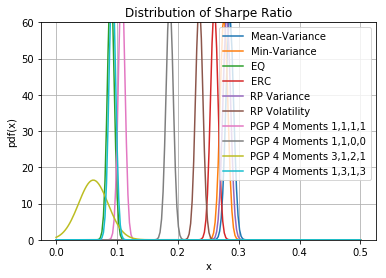

In [49]:
#Distribution of Sharpe Ratio Using Skewness and Kurtosis (Work in progress)
#https://quantdare.com/probabilistic-sharpe-ratio/ 
n = len(returns)
fig, ax = plt.subplots()
x = np.linspace(0,0.5,200)
for i in historical_performance.index:
    SR_std = (1 + 0.5* historical_performance.loc[i, 'Sharpe Ratio']**0.5 - historical_performance.loc[i, 'Skewness']*historical_performance.loc[i, 'Sharpe Ratio'] + (historical_performance.loc[i, 'Kurtosis']/4) * historical_performance.loc[i, 'Sharpe Ratio']**0.5)/(n - 1)
    ax.plot(x, norm.pdf(x,loc= historical_performance.loc[i, 'Sharpe Ratio'], 
                        scale = SR_std), label= i)

ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.set_title('Distribution of Sharpe Ratio')
ax.legend(loc='best', frameon=True)
ax.set_ylim(0,60)
ax.grid(True)

In [6]:
#Utility functions
#Polynomial goal programming (PGP)
#Max return, min variance, max skewness, min kurtosis - determine weights
#Utility functions
#1. MV (mu - gamma*sigma**2) - assumes doesn't care about skew & kurt
#2. Power (1/gamma * wealth**gamma)/CRRA
#3. S-Shaped value function
#4. exponential
#5. log i.e. kelly rule
#Rule to compare 100% max tolerable volatility and optimal portfolio + cash
#Measure of risk that incorporates scenarios (not standard deviation)

In [7]:
#Rolling window Performance
#Assumes rebalancing every month
#To be incorporated: Market weights, Diversity weights, Kelly Rule, fundamentally-weighted (Arnott et al 2005), Proportional to Sharpe Ratio
rolling_sample = returns.rolling(60) #5 years
strategies = pd.DataFrame(index = rolling_sample.mean().index, 
                          columns = ['Mean-Variance Weights','Mean-Variance Return', 
                                     'EQ Weights', 'EQ Return', 
                                     'Min-Variance Weights', 'Min-Variance Return', 
                                     'ERC Weights', 'ERC Return', 'RP Variance Weights', 'RP Variance Return', 
                                     'RP Volatility Weights', 'RP Volatility Return']) 

for i in rolling_sample.mean().index:
    rolling_sample_return = opt.matrix(rolling_sample.mean().loc[i])
    rolling_sample_cov = opt.matrix(rolling_sample.cov().loc[i].values)
    if np.linalg.matrix_rank(rolling_sample_return) > 0:
        weights, port_returns, std, index = mvo(rolling_sample_return, rolling_sample_cov)
        strategies['Mean-Variance Weights'].loc[i] = weights[index]
        strategies['Min-Variance Weights'].loc[i] = weights[99]
        strategies['EQ Weights'].loc[i] = equal_weight(returns)
        strategies['ERC Weights'].loc[i] = equal_risk_contribution(rolling_sample_cov)
        strategies['RP Variance Weights'].loc[i] = risk_parity_variance(returns)
        strategies['RP Volatility Weights'].loc[i] = risk_parity_volatility(returns)

for i in range(len(strategies)):
    if np.isnan(strategies['Mean-Variance Weights'].shift(1)[i]).any() != True:
        strategies['Mean-Variance Return'][i] =  np.dot(strategies['Mean-Variance Weights'].shift(1)[i][0:len(returns.columns) - 1].T, returns.iloc[i, 0:(len(returns.columns) - 1)])[0]
        strategies['Min-Variance Return'][i] =  np.dot(strategies['Min-Variance Weights'].shift(1)[i][0:len(returns.columns) - 1].T, returns.iloc[i, 0:(len(returns.columns) - 1)])[0]
        strategies['EQ Return'][i] =  np.dot(strategies['EQ Weights'].shift(1)[i][0:len(returns.columns) - 1].T, returns.iloc[i, 0:(len(returns.columns) - 1)])[0]
        strategies['ERC Return'][i] =  np.dot(strategies['ERC Weights'].shift(1)[i][0:len(returns.columns) - 1].T, returns.iloc[i, 0:(len(returns.columns) - 1)])[0]
        strategies['RP Variance Return'][i] =  np.dot(strategies['RP Variance Weights'].shift(1)[i][0:len(returns.columns) - 1].T, returns.iloc[i, 0:(len(returns.columns) - 1)])[0]
        strategies['RP Volatility Return'][i] =  np.dot(strategies['RP Volatility Weights'].shift(1)[i][0:len(returns.columns) - 1].T, returns.iloc[i, 0:(len(returns.columns) - 1)])[0]  
        
strategies.tail()

C:\Users\maxru\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1855: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


,Mean-Variance Weights,Mean-Variance Return,EQ Weights,EQ Return,Min-Variance Weights,Min-Variance Return,ERC Weights,ERC Return,RP Variance Weights,RP Variance Return,RP Volatility Weights,RP Volatility Return
Date,,,,,,,,,,,,
2019-01-31,"[0.6262200671186033, 0.373779270821714, 6.1216...",0.0301883,"[0.25, 0.25, 0.25, 0.25]",0.0432069,"[0.7523686102102964, 0.1637157788758469, 5.979...",0.0205047,"[0.6023685864805187, 0.1713645273876229, 0.102...",0.0274076,"[0.7270632060355307, 0.18285953640552285, 0.08...",0.0274424,"[0.5285084566686611, 0.2650480811591346, 0.184...",0.0407486
2019-02-28,"[0.6250426243918641, 0.37495683935247415, 4.85...",0.00717373,"[0.25, 0.25, 0.25, 0.25]",0.0064567,"[0.7468196748560958, 0.16849816526974043, 5.45...",3.83211e-05,"[0.600855773216291, 0.17319332548090455, 0.102...",0.00147369,"[0.7270632060355307, 0.18285953640552285, 0.08...",0.000978144,"[0.5285084566686611, 0.2650480811591346, 0.184...",0.00495429
2019-03-31,"[0.6451081542453954, 0.3548914250130074, 3.441...",0.0242919,"[0.25, 0.25, 0.25, 0.25]",0.0131305,"[0.741117886810446, 0.17752203958238025, 5.041...",0.0253534,"[0.5916417798263839, 0.17720786894883633, 0.10...",0.0217514,"[0.7270632060355307, 0.18285953640552285, 0.08...",0.0256765,"[0.5285084566686611, 0.2650480811591346, 0.184...",0.0214096
2019-04-30,"[0.6136999554721335, 0.3862997452329231, 2.571...",0.00822028,"[0.25, 0.25, 0.25, 0.25]",0.0124375,"[0.7417230599595348, 0.17652838156823217, 4.99...",0.00128141,"[0.5934740425574464, 0.1761276472237335, 0.105...",0.00451617,"[0.7270632060355307, 0.18285953640552285, 0.08...",0.00343658,"[0.5285084566686611, 0.2650480811591346, 0.184...",0.0097134
2019-05-31,"[0.6642923753098245, 0.3357073113836707, 2.566...",-0.000298886,"[0.25, 0.25, 0.25, 0.25]",-0.0236079,"[0.7348848589705032, 0.18341072838715652, 5.17...",0.0163926,"[0.6024392608170661, 0.17195418268250895, 0.10...",0.00343261,"[0.7270632060355307, 0.18285953640552285, 0.08...",0.00905436,"[0.5285084566686611, 0.2650480811591346, 0.184...",-0.00976208


In [ ]:
rolling_sample.apply()

In [47]:
#Rolling Window Performance Summary
summary = pd.DataFrame(index = ['Mean-Variance', 'Min-Variance', 'EQ', 'ERC', 'RP Variance', 'RP Volatility'], 
                          columns = ['Average Weights','Average Return','Average Volatility', 'Average Sharpe Ratio']) 
for k in summary.index:
    weights = [0] * len(returns.columns)
    for j in range(len(returns.columns)):
        x = 0
        for i in range(len(strategies[k + ' Weights'][~pd.isnull(strategies[k + ' Weights'])])):
            x = x + strategies[k + ' Weights'][~pd.isnull(strategies[k + ' Weights'])][i][j]
        average = x/len(strategies[k + ' Weights'][~pd.isnull(strategies[k + ' Weights'])])
        weights[j] = average
    summary.loc[k, 'Average Return'] = np.mean(strategies[k + ' Return'][~pd.isnull(strategies[k + ' Return'])])
    summary.loc[k, 'Average Volatility'] = np.var(strategies[k + ' Return'][~pd.isnull(strategies[k + ' Return'])])**0.5
    summary.loc[k, 'Average Weights'] = list(np.around(weights, 2))    

summary['Average Sharpe Ratio'] = summary['Average Return']/summary['Average Volatility']
summary

,Average Weights,Average Return,Average Volatility,Average Sharpe Ratio
Mean-Variance,"[0.65, 0.22, 0.11, 0.02]",0.00470465,0.0198115,0.23747
Min-Variance,"[0.72, 0.24, 0.0, 0.05]",0.00384992,0.0165168,0.233092
EQ,"[0.25, 0.25, 0.25, 0.25]",0.00394678,0.0248502,0.158823
ERC,"[0.6, 0.2, 0.12, 0.09]",0.0041534,0.0181829,0.228423
RP Variance,"[0.73, 0.18, 0.09, 0.0]",0.00446022,0.0171472,0.260113
RP Volatility,"[0.53, 0.27, 0.18, 0.02]",0.00473343,0.0221492,0.213707


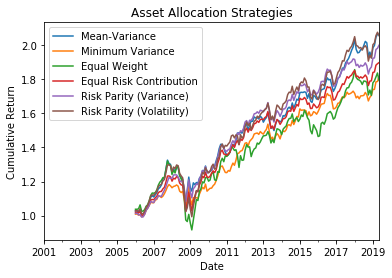

In [48]:
#Cumulative return
np.cumprod(strategies['Mean-Variance Return'] + 1).plot()
np.cumprod(strategies['Min-Variance Return'] + 1).plot()
np.cumprod(strategies['EQ Return'] + 1).plot()
np.cumprod(strategies['ERC Return'] + 1).plot()
np.cumprod(strategies['RP Variance Return'] + 1).plot()
np.cumprod(strategies['RP Volatility Return'] + 1).plot()
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Asset Allocation Strategies')
plt.legend(['Mean-Variance', 'Minimum Variance', 'Equal Weight', 'Equal Risk Contribution', 'Risk Parity (Variance)', 'Risk Parity (Volatility)'])
plt.show()

In [ ]:
#Time series of Sharpe Ratio (running)